In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

import numpy as np
import pandas as pd
import random
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple

from scandy.models.LocationModel import LocationModel
from scandy.models.ObjectModel import ObjectModel
from scandy.utils.dataclass import Dataset
import scandy.utils.functions as uf

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

/beegfs/home/users/n/nicolas-roth/ScanDy


Load the dataset with the randomly generated train-test split used in the paper.

In [2]:
vidlist = sorted(['dance01', 'dance02', 'field03', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park01', 'park06', 'park09', 'road02', 'road04', 'road05', 'robarm01', 'room01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02', 'walkway03'])
random.seed(12345)
trainlist = sorted(random.sample(vidlist, 10))
testlist = sorted([vidname for vidname in vidlist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)

datadict = {
    "PATH": "/scratch/nroth/VidCom/VidCom/", # HPC
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : '2021-12-04_VidCom_GT_fov_df',
    'gt_fovframes_nss_df' : 'gt_fovframes_nss_df.csv',
    'trainset' : trainlist,
    'testset' : testlist,
}
VidCom = Dataset(datadict)

trainlist =  ['dance01', 'dance02', 'garden06', 'garden07', 'park01', 'park06', 'road02', 'road05', 'room01', 'walkway03'] 
testlist = ['field03', 'foutain02', 'garden04', 'garden09', 'park09', 'road04', 'robarm01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']


Get the ground truth human data

In [3]:
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values

gt_amp_dva_train = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms_train = VidCom.train_foveation_df["duration_ms"].dropna().values

gt_amp_dva_test = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms_test = VidCom.test_foveation_df["duration_ms"].dropna().values

Fit distributions to the histograms and scale them appropriately

In [5]:
ampfit = stats.expon.fit(gt_amp_dva)
ampX = np.linspace(0,50, 200)
ampPDF = stats.expon.pdf(ampX, *ampfit)

durfit = stats.norm.fit(np.log10(gt_dur_ms))
durX = np.linspace(1,4, 200)
durPDF = stats.norm.pdf(durX, *durfit)
print(durfit, ampfit)

c_count, b_count = np.histogram(np.log10(gt_dur_ms), density=False,bins=40)
c_dense, b_dense = np.histogram(np.log10(gt_dur_ms), density=True,bins=40)
FD_fac = c_count.max()/c_dense.max()
c_count, b_count = np.histogram(gt_amp_dva, density=False,bins=60)
c_dense, b_dense = np.histogram(gt_amp_dva, density=True,bins=60)
SA_fac = c_count.max()/c_dense.max()

(2.490587926154523, 0.363944013720007) (0.06, 9.226529970987196)


In [4]:
print("report with basis e: ", stats.norm.fit(np.log(gt_dur_ms)))
print("expected value is ", np.exp(5.734790631554358 + 0.5 * 0.8380120606761086**2))

report with basis e:  (5.734790631554358, 0.8380120606761086)
expected value is  439.6252847362015


## Fig 4
### a & b
Ground truth scanpath statistics.

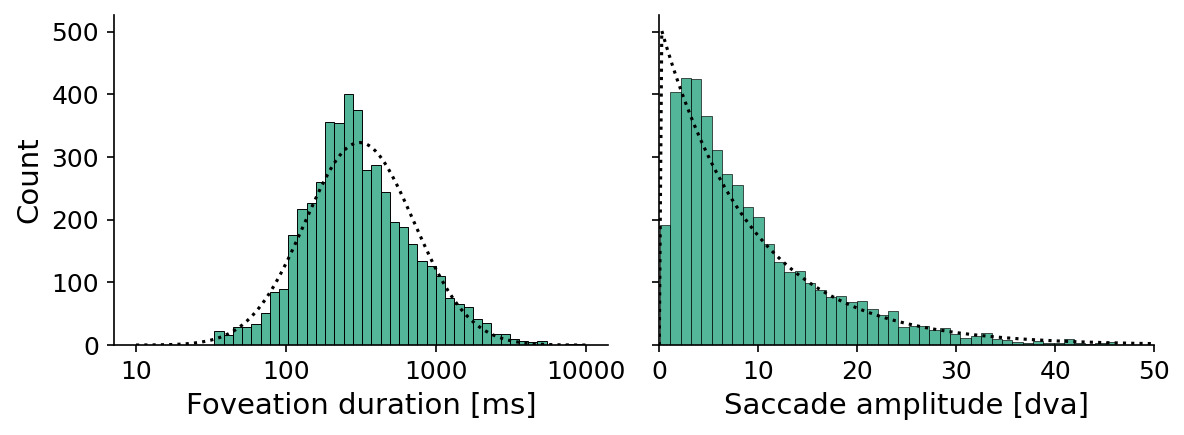

In [6]:
# use different color palatte from the functional evaluation (see below)
cl = sns.color_palette("Dark2")

fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0], bins=40, color=cl[0])
axs[0].plot(durX, durPDF*FD_fac, color='k', ls=':')
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels([10,100,1000,10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Count', size=14)
sns.histplot(data=gt_amp_dva, kde=False, ax=axs[1], bins=60, color=cl[0])
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].set_xlim([0, 50])
axs[1].plot(ampX, ampPDF*SA_fac, color='k', ls=':', label='Fit')
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)
sns.despine()
plt.tight_layout(); plt.show()

### c & d
Compare the CDF summary statistics of the human data with the models. Show training in transparent and test in opaque.

train
test


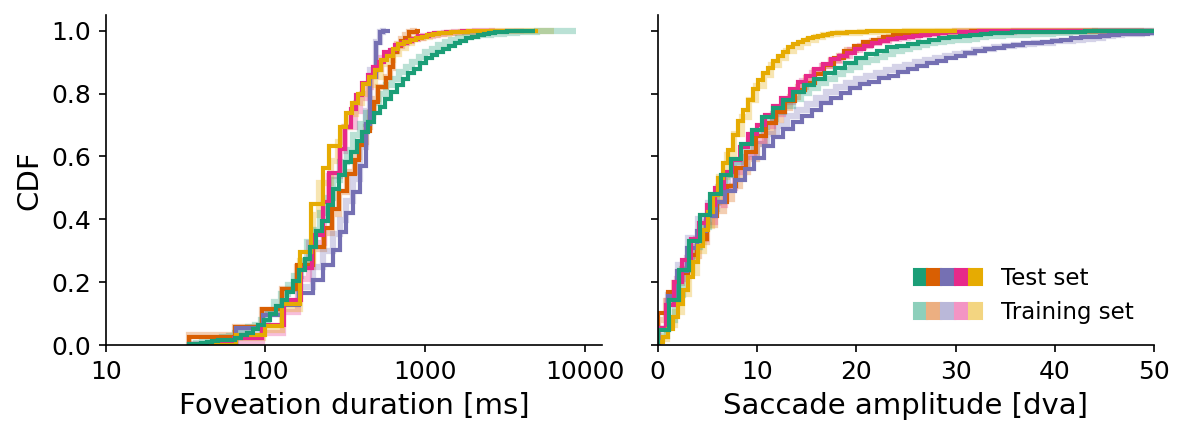

In [7]:
cl = sns.color_palette("Dark2")

names = [ 'L.ll', 'L.hl', 'O.ll', 'O.cb']
gtname = 'Human data'
run_ids = [
    'loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349',
    'loc_train_TASEDnet_64-32-50_2023-03-09-01H-02M-20S_22332348',
    'obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350',
    'obj_train_None_64-32-50_2023-03-09-01H-05M-43S_22332351',
]
# prepare custom legend
handles1 = []; handles2 = []
for ind in [0,1,2,3,5]:
    rgb = to_rgb(cl[ind])
    handles1.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    handles2.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))

fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
for modus in ["train", "test"]:
    c_idx = 0
    print(modus)

    if modus == "train":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        kwargs = {"lw":3, "alpha":0.3} #"ls":"dotted", 
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        kwargs = {"lw":2}#, "ls":"dotted", "alpha":0.5}

    df_res_pxMolin_top0 = pd.read_csv(f'./results/{run_ids[0]}/{modus}res_df_top0.csv')
    # df_res_pxMolin_top0 = df_res_pxMolin_top0[df_res_pxMolin_top0['video'].isin(videoset)]
    px_llf_dur_ms = df_res_pxMolin_top0["duration_ms"].dropna().values
    px_llf_amp_dva = df_res_pxMolin_top0["sac_amp_dva"].dropna().values

    df_res_pxTased_top0 = pd.read_csv(f'./results/{run_ids[1]}/{modus}res_df_top0.csv')
    # df_res_pxTased_top0 = df_res_pxTased_top0[df_res_pxTased_top0['video'].isin(videoset)]
    px_hlf_dur_ms = df_res_pxTased_top0["duration_ms"].dropna().values 
    px_hlf_amp_dva = df_res_pxTased_top0["sac_amp_dva"].dropna().values 

    df_res_objMolin_top0 = pd.read_csv(f'./results/{run_ids[2]}/{modus}res_df_top0.csv')
    # df_res_objMolin_top0 = df_res_objMolin_top0[df_res_objMolin_top0['video'].isin(videoset)]
    obj_llf_dur_ms = df_res_objMolin_top0["duration_ms"].dropna().values
    obj_llf_amp_dva = df_res_objMolin_top0["sac_amp_dva"].dropna().values

    df_res_objNone_top0 = pd.read_csv(f'./results/{run_ids[3]}/{modus}res_df_top0.csv')
    # df_res_objNone_top0 = df_res_objNone_top0[df_res_objNone_top0['video'].isin(videoset)]
    obj_cb_dur_ms = df_res_objNone_top0["duration_ms"].dropna().values
    obj_cb_amp_dva = df_res_objNone_top0["sac_amp_dva"].dropna().values

    nbins = 60
    axs[0].hist(np.log10(px_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[0], color=cl[1], **kwargs)
    axs[0].hist(np.log10(px_hlf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[1], color=cl[2], **kwargs)
    axs[0].hist(np.log10(obj_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[2], color=cl[3], **kwargs)
    axs[0].hist(np.log10(obj_cb_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[3], color=cl[5], **kwargs)
    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[0].set_xticks([1,2,3,4])
    axs[0].set_xticklabels([10,100,1000,10000], size=14)
    axs[0].tick_params(labelsize=12)
    axs[0].set_xlabel('Foveation duration [ms]', size=14)
    axs[0].set_ylabel('CDF', size=14)
    axs[1].hist(px_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[0], color=cl[1], **kwargs)
    axs[1].hist(px_hlf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[1], color=cl[2], **kwargs)
    axs[1].hist(obj_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[2], color=cl[3], **kwargs)
    axs[1].hist(obj_cb_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[3], color=cl[5], **kwargs)
    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
    axs[1].tick_params(labelsize=12)
    axs[1].set_xlim([0, 50])
    #axs[1].legend(loc='lower right')
    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])
axs[1].legend(bbox_to_anchor=(1,0), loc='lower right', 
            frameon=False, handles=[tuple(handles1), tuple(handles2)], labels=["Test set", "Training set"],
            title="", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize=11)

sns.despine(); plt.tight_layout(); plt.show()


In [8]:
np.max(px_hlf_dur_ms)

600.0

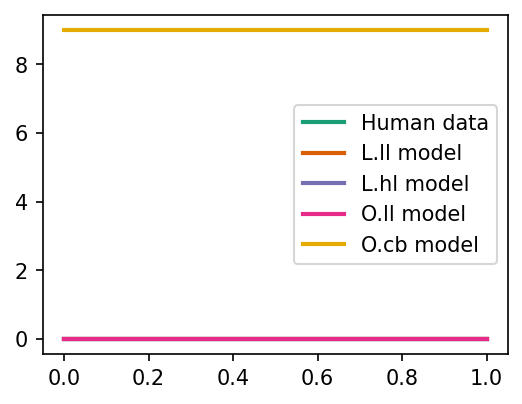

In [9]:
# create legend separately
fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
ax.plot([0,1], [0,0], lw=2, label=gtname, color=cl[0])
ax.plot([0,1], [0,0], lw=2, label="L.ll model", color=cl[1])#names[0])
ax.plot([0,1], [0,0], lw=2, label="L.hl model", color=cl[2])#names[1])
ax.plot([0,1], [0,0], lw=2, label="O.ll model", color=cl[3])#names[2])
ax.plot([0,1], [9,9], lw=2, label="O.cb model", color=cl[5])#names[3])
plt.legend()
plt.show()

## Fig 5

### a) Foveation categories over time for human data

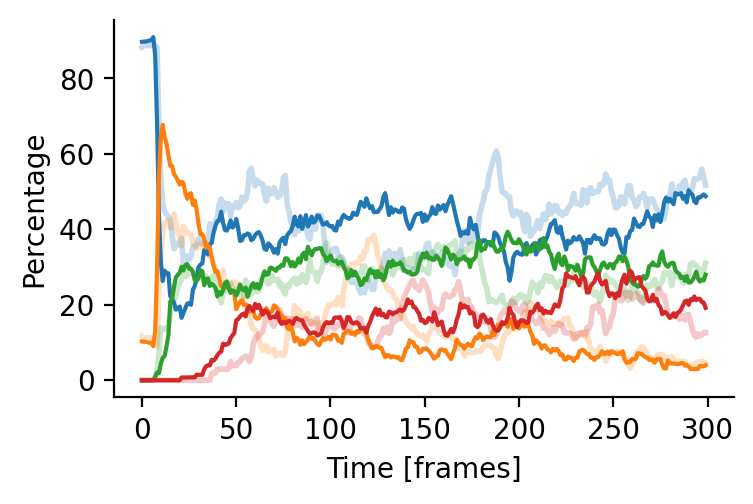

In [10]:
cl = sns.color_palette()

BDIR_per_frames_train = np.zeros((4,300))
BDIR_per_frames = np.zeros((4,300))
bdir_to_row = {'B': 0, 'D': 1, 'I': 2, 'R': 3}
for index, row in VidCom.train_foveation_df.iterrows():
    BDIR_per_frames_train[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1
for index, row in VidCom.test_foveation_df.iterrows():
    BDIR_per_frames[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1

combined_per_frames_train = np.sum(BDIR_per_frames_train, axis=0)
combined_per_frames = np.sum(BDIR_per_frames, axis=0)

fig, ax = plt.subplots(dpi=200, figsize=(4,2.5))
ax.plot(BDIR_per_frames_train[0] / combined_per_frames_train * 100, color=cl[0], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[1] / combined_per_frames_train * 100, color=cl[1], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[2] / combined_per_frames_train * 100, color=cl[2], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[3] / combined_per_frames_train * 100, color=cl[3], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames[0] / combined_per_frames * 100, color=cl[0], label='Background')
ax.plot(BDIR_per_frames[1] / combined_per_frames * 100, color=cl[1], label='Detection')
ax.plot(BDIR_per_frames[2] / combined_per_frames * 100, color=cl[2], label='Inspection')
ax.plot(BDIR_per_frames[3] / combined_per_frames * 100, color=cl[3], label='Revisit')
ax.set(xlabel='Time [frames]', ylabel='Percentage') # title='Ground truth foveation category over time', 
# plt.legend(); 
sns.despine(); plt.show()


For the supplement, check the temporally resolved ratios for all models! 

L.ll


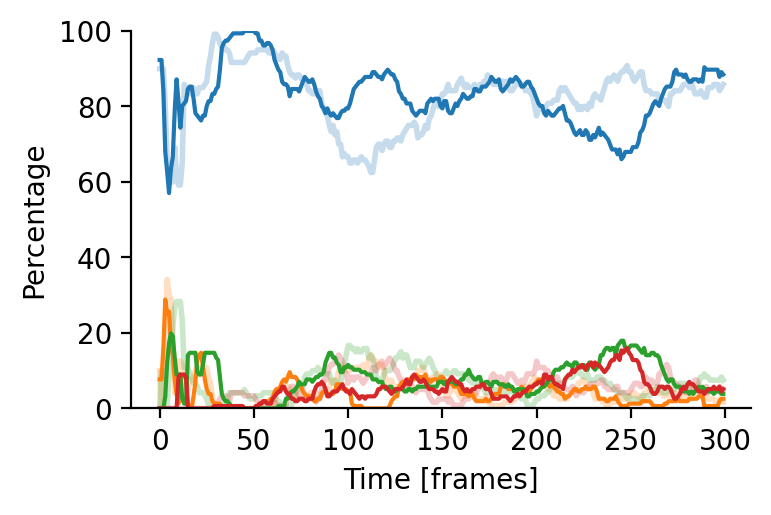

L.hl


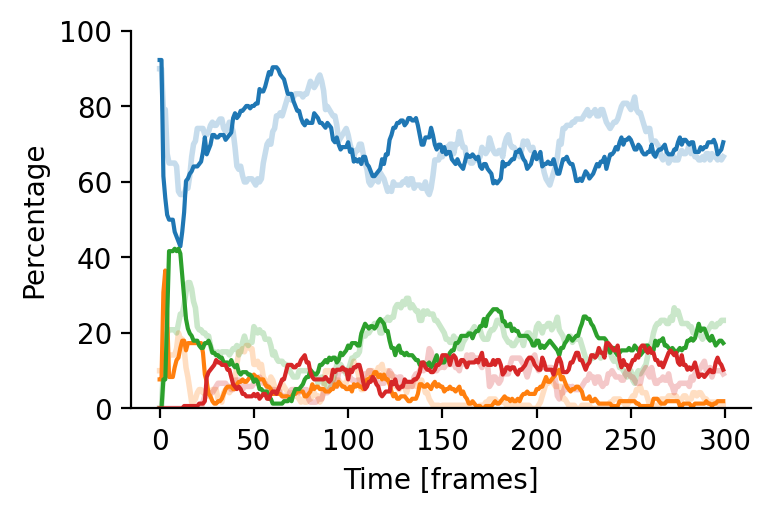

O.ll


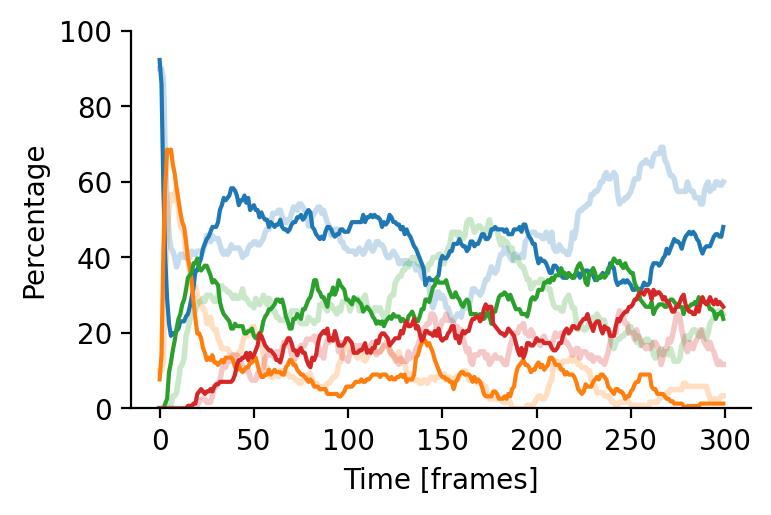

O.cb


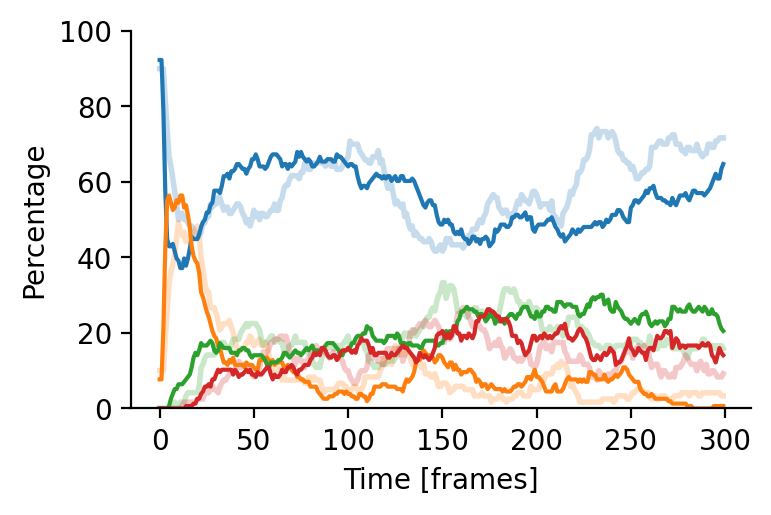

In [11]:
for model_idx in range(4):
    runid = run_ids[model_idx]
    name = names[model_idx]
    
    if 'obj_' in runid:
        model = ObjectModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'loc_' in runid:
        model = LocationModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    else:
        raise NotImplementedError("Only Object- and Location-based are implemented")

    train_df = pd.read_csv(f'results/{runid}/trainres_df_top{0}.csv')
    test_df = pd.read_csv(f'results/{runid}/testres_df_top{0}.csv')
    model.result_df = pd.concat([train_df, test_df], ignore_index=True)

    ratios = model.functional_event_courses(videos_to_eval="test")
    ratios_train = model.functional_event_courses(videos_to_eval="train")

    print(name)
    fig, ax = plt.subplots(dpi=200, figsize=(4,2.5))
    ax.plot(ratios_train[0], color=cl[0], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[1], color=cl[1], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[2], color=cl[2], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[3], color=cl[3], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios[0], color=cl[0], label='Background')
    ax.plot(ratios[1], color=cl[1], label='Detection')
    ax.plot(ratios[2], color=cl[2], label='Inspection')
    ax.plot(ratios[3], color=cl[3], label='Revisit')
    # ax.set(title=name, xlabel='Time [frames]', ylabel='Percentage', ylim=[0,100]) # title='Ground truth foveation category over time', 
    ax.set(xlabel='Time [frames]', ylabel='Percentage', ylim=[0,100]) # title='Ground truth foveation category over time', 
    sns.despine(); plt.show()

In main paper, reduce this to the barplot of the mean ratios, which is calculated afterwards.
First, look into the train/test boxplots!

## Fig 6: BDIR fractions relative to the human data


In [13]:
print("Fraction of the stimulus time taken up by foveation events in the human data: ", VidCom.get_foveation_ratio())
print("This is 100% for the models.")

Fraction of the stimulus time taken up by foveation events in the human data:  0.7839665164874551
This is 100% for the models.


MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7f4cc2743b00>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7f4cc6a903b0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7f4cc2743f80>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7f4cc2743cb0>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7f4cc2743d40>


loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349 mean params
ddm_thres = $0.355 \pm 0.037$     & 0.313
ddm_sig = $0.013 \pm 0.001$     & 0.012
att_dva = $12.77 \pm 0.51$     & 13.57
ior_decay = $226.5 \pm 37.5$     & 265.7
ior_dva = $6.82 \pm 0.32$     & 7.12
Balancing of fitness function
$d_{FD} = 0.11 \pm 0.009$   top0: 0.114
$d_{SA} = 0.092 \pm 0.011$   top0: 0.071
Train,  L.ll [0.83438976 0.0478941  0.07050955 0.0472066 ]
Test,  L.ll [0.83746127 0.03640692 0.0757265  0.05040532]
Test ratio to GT,  L.ll [2.07758683 0.25284182 0.25908167 0.31380211]
loc_train_TASEDnet_64-32-50_2023-03-09-01H-02M-20S_22332348


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


loc_train_TASEDnet_64-32-50_2023-03-09-01H-02M-20S_22332348 mean params
ddm_thres = $1.469 \pm 0.054$     & 1.441
ddm_sig = $0.082 \pm 0.003$     & 0.082
att_dva = $10.39 \pm 0.95$     & 10.24
ior_decay = $272.9 \pm 14.8$     & 278.8
ior_dva = $4.3 \pm 0.09$     & 4.26
Balancing of fitness function
$d_{FD} = 0.21 \pm 0.008$   top0: 0.212
$d_{SA} = 0.068 \pm 0.008$   top0: 0.057
Train,  L.hl [0.6832474  0.05017014 0.1904566  0.07612587]
Test,  L.hl [0.68612179 0.04894164 0.16973758 0.09519899]
Test ratio to GT,  L.hl [1.70214152 0.33989402 0.58072006 0.59266849]
obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350 mean params
ddm_thres = $1.873 \pm 0.142$     & 1.828
ddm_sig = $0.241 \pm 0.009$     & 0.247
att_dva = $13.72 \pm 1.16$     & 13.63
ior_decay = $198.9 \pm 39.4$     & 161.8
ior_inobj = $0.76 \pm 0.05$     & 0.79
Balancing of fitness function
$d_{FD} = 0.133 \pm 0.01$   top0: 0.122
$d_{SA} = 0.055 \pm 0.01$   top0: 0.054
Train,  O.ll [0.48074479 0.09622483 0.2796849  0.14334549]
Test,  O.ll [0.42330996 0.10506611 0.32229567 0.14932826]
Test ratio to GT,  O.ll [1.05015388 0.72967193 1.10266425 0.92965438]
obj_train_None_64-32-50_2023-03-09-01H-05M-43S_22332351


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


obj_train_None_64-32-50_2023-03-09-01H-05M-43S_22332351 mean params
ddm_thres = $2.862 \pm 0.101$     & 2.953
ddm_sig = $0.209 \pm 0.03$     & 0.223
att_dva = $6.14 \pm 0.2$     & 6.32
ior_decay = $133.1 \pm 52.8$     & 155.2
ior_inobj = $0.94 \pm 0.01$     & 0.94
Balancing of fitness function
$d_{FD} = 0.123 \pm 0.008$   top0: 0.114
$d_{SA} = 0.189 \pm 0.008$   top0: 0.175
Train,  O.cb [0.5665434  0.09302865 0.19029253 0.15013542]
Test,  O.cb [0.55986846 0.09681357 0.18272703 0.16059095]
Test ratio to GT,  O.cb [1.3889303  0.67235901 0.62516062 0.99977109]


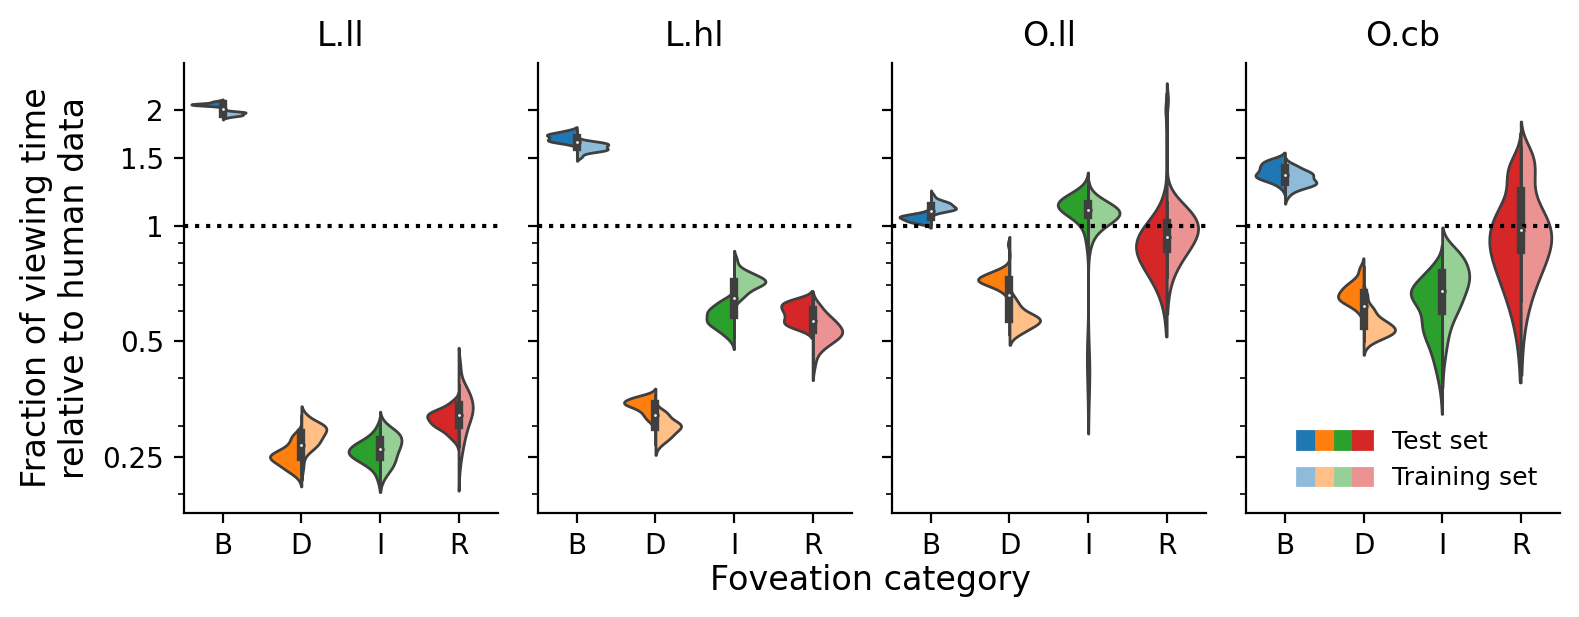

In [14]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,3), dpi=200)
report_par_decimals = [3,3,2,1,2]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())

mean_fovcats_train = []
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'obj_' in runid:
        model = ObjectModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'loc_' in runid:
        model = LocationModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in test simulation results
    test_fovcats = []
    for i in range(32):
        model.result_df = pd.read_csv(f'results/{runid}/testres_df_top{i}.csv')
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['test_fov_cat'] = test_fovcats

    print(runid, "mean params")
    for i, par in enumerate(parameters):
        top_par = round(df_top32[par].iloc[0],report_par_decimals[i])
        print(f'{par} = ${round(df_top32[par].mean(),report_par_decimals[i])} \pm {round(df_top32[par].std(),report_par_decimals[i])}$     & {top_par}' )
    print("Balancing of fitness function")
    print("$d_{FD} =", f'{round(df_top32["f0"].mean(), 3)} \pm {round(df_top32["f0"].std(), 3)}$   top0: {round(df_top32["f0"].iloc[0], 3)}' )
    print("$d_{SA} =", f'{round(df_top32["f1"].mean(), 3)} \pm {round(df_top32["f1"].std(), 3)}$   top0: {round(df_top32["f1"].iloc[0], 3)}' )


    fovcats_train = [df_top32['fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='training set')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='test set')
    cdf = pd.concat([df_test_fovcats_rel_gt, df_train_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name=['Foveation category'])

    sns.violinplot(x="Foveation category", y="value", hue="Data", data=mdf, ax=ax, split=True, linewidth=1, palette={"test set": cl[0], "training set": ".85"})    
    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(cl[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    ax.set_yscale('log')
    ax.set_yticks([0.25,0.5,1,1.5,2])
    ax.set_yticklabels([0.25,0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')

    if (ax_i%4)==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    if ax_i==3:
        ax.legend(bbox_to_anchor=(1,0), loc='lower right', 
                  frameon=False, handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Test set", "Training set"],
                  title="", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize=9)
    else:
        ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_title(names[ax_i])
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine(); plt.show()

In [15]:
subjects_fovcat_train

[0.4259663789866386,
 0.16730111098243414,
 0.2655765640469341,
 0.14115594598399314]

In [16]:
subjects_fovcat_test

[0.4030932711138888,
 0.143990883823684,
 0.29228813057935943,
 0.16062771448306778]

## Fig 5b Barplots
Use the means from the distributions plotted in Fig 6

Trainset


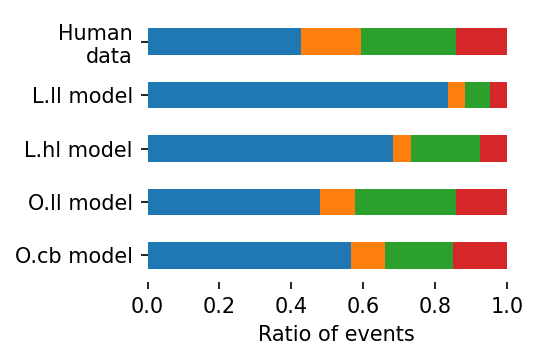

Testset


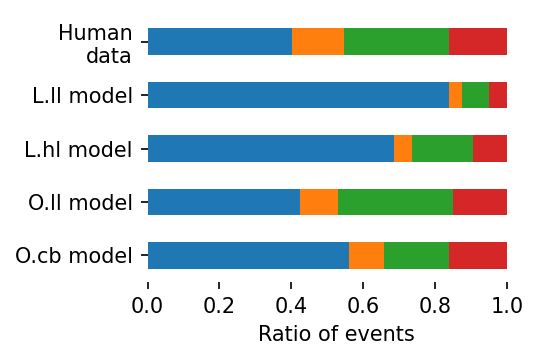

In [20]:
# names_r = names[::-1]
names_r = ["O.cb model", "O.ll model", "L.hl model", "L.ll model"]
mean_fovcats_train_r = mean_fovcats_train[::-1]
mean_fovcats_test_r = mean_fovcats_test[::-1]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())

df_fovcats_train = pd.DataFrame(index=names_r + ['Human\ndata'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_train_r + [subjects_fovcat_train/sum(subjects_fovcat_train)])
df_fovcats_test = pd.DataFrame(index=names_r + ['Human\ndata'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_test_r + [subjects_fovcat_test/sum(subjects_fovcat_test)])

# fig, ax = plt.subplots(figsize=(3.5,2.5),dpi=150)
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_train.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Trainset')
print("Trainset")
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_test.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Testset')
print("Testset")
plt.tight_layout(); plt.show()


# Supplemental material

In [21]:
videos = sorted(VidCom.gt_foveation_df.video.unique())

# go through all videos and print a list that says for each if it is in the training or test set 
print(f"Name\t \t#Subjects\t \tTrain/test set")
for video in videos:
    nsubj = len(VidCom.gt_foveation_df[VidCom.gt_foveation_df.video==video].subject.unique())
    if video in VidCom.trainset:
        print(f"{video}\t \t{nsubj}\t \ttrain")
    else:
        print(f"{video}\t \t{nsubj}\t \ttest")


Name	 	#Subjects	 	Train/test set
dance01	 	12	 	train
dance02	 	14	 	train
field03	 	12	 	test
foutain02	 	14	 	test
garden04	 	12	 	test
garden06	 	14	 	train
garden07	 	13	 	train
garden09	 	12	 	test
park01	 	12	 	train
park06	 	12	 	train
park09	 	11	 	test
road02	 	11	 	train
road04	 	11	 	test
road05	 	11	 	train
robarm01	 	12	 	test
room01	 	10	 	train
room02	 	12	 	test
room03	 	10	 	test
tommy02	 	13	 	test
uscdog01	 	12	 	test
walkway01	 	13	 	test
walkway02	 	13	 	test
walkway03	 	13	 	train


## S1 & S2 are about parameter understanding and robustness for both models

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7ff1c4ce4050>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7ff1c90ac8c0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7ff1c4ce44d0>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7ff1c4ce4200>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7ff1c4ce4290>
MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


{'ddm_thres': 0.3553117207034865, 'ddm_sig': 0.012601165350345118, 'att_dva': 12.769672695739247, 'ior_decay': 226.47581103483776, 'ior_dva': 6.8241286297442}


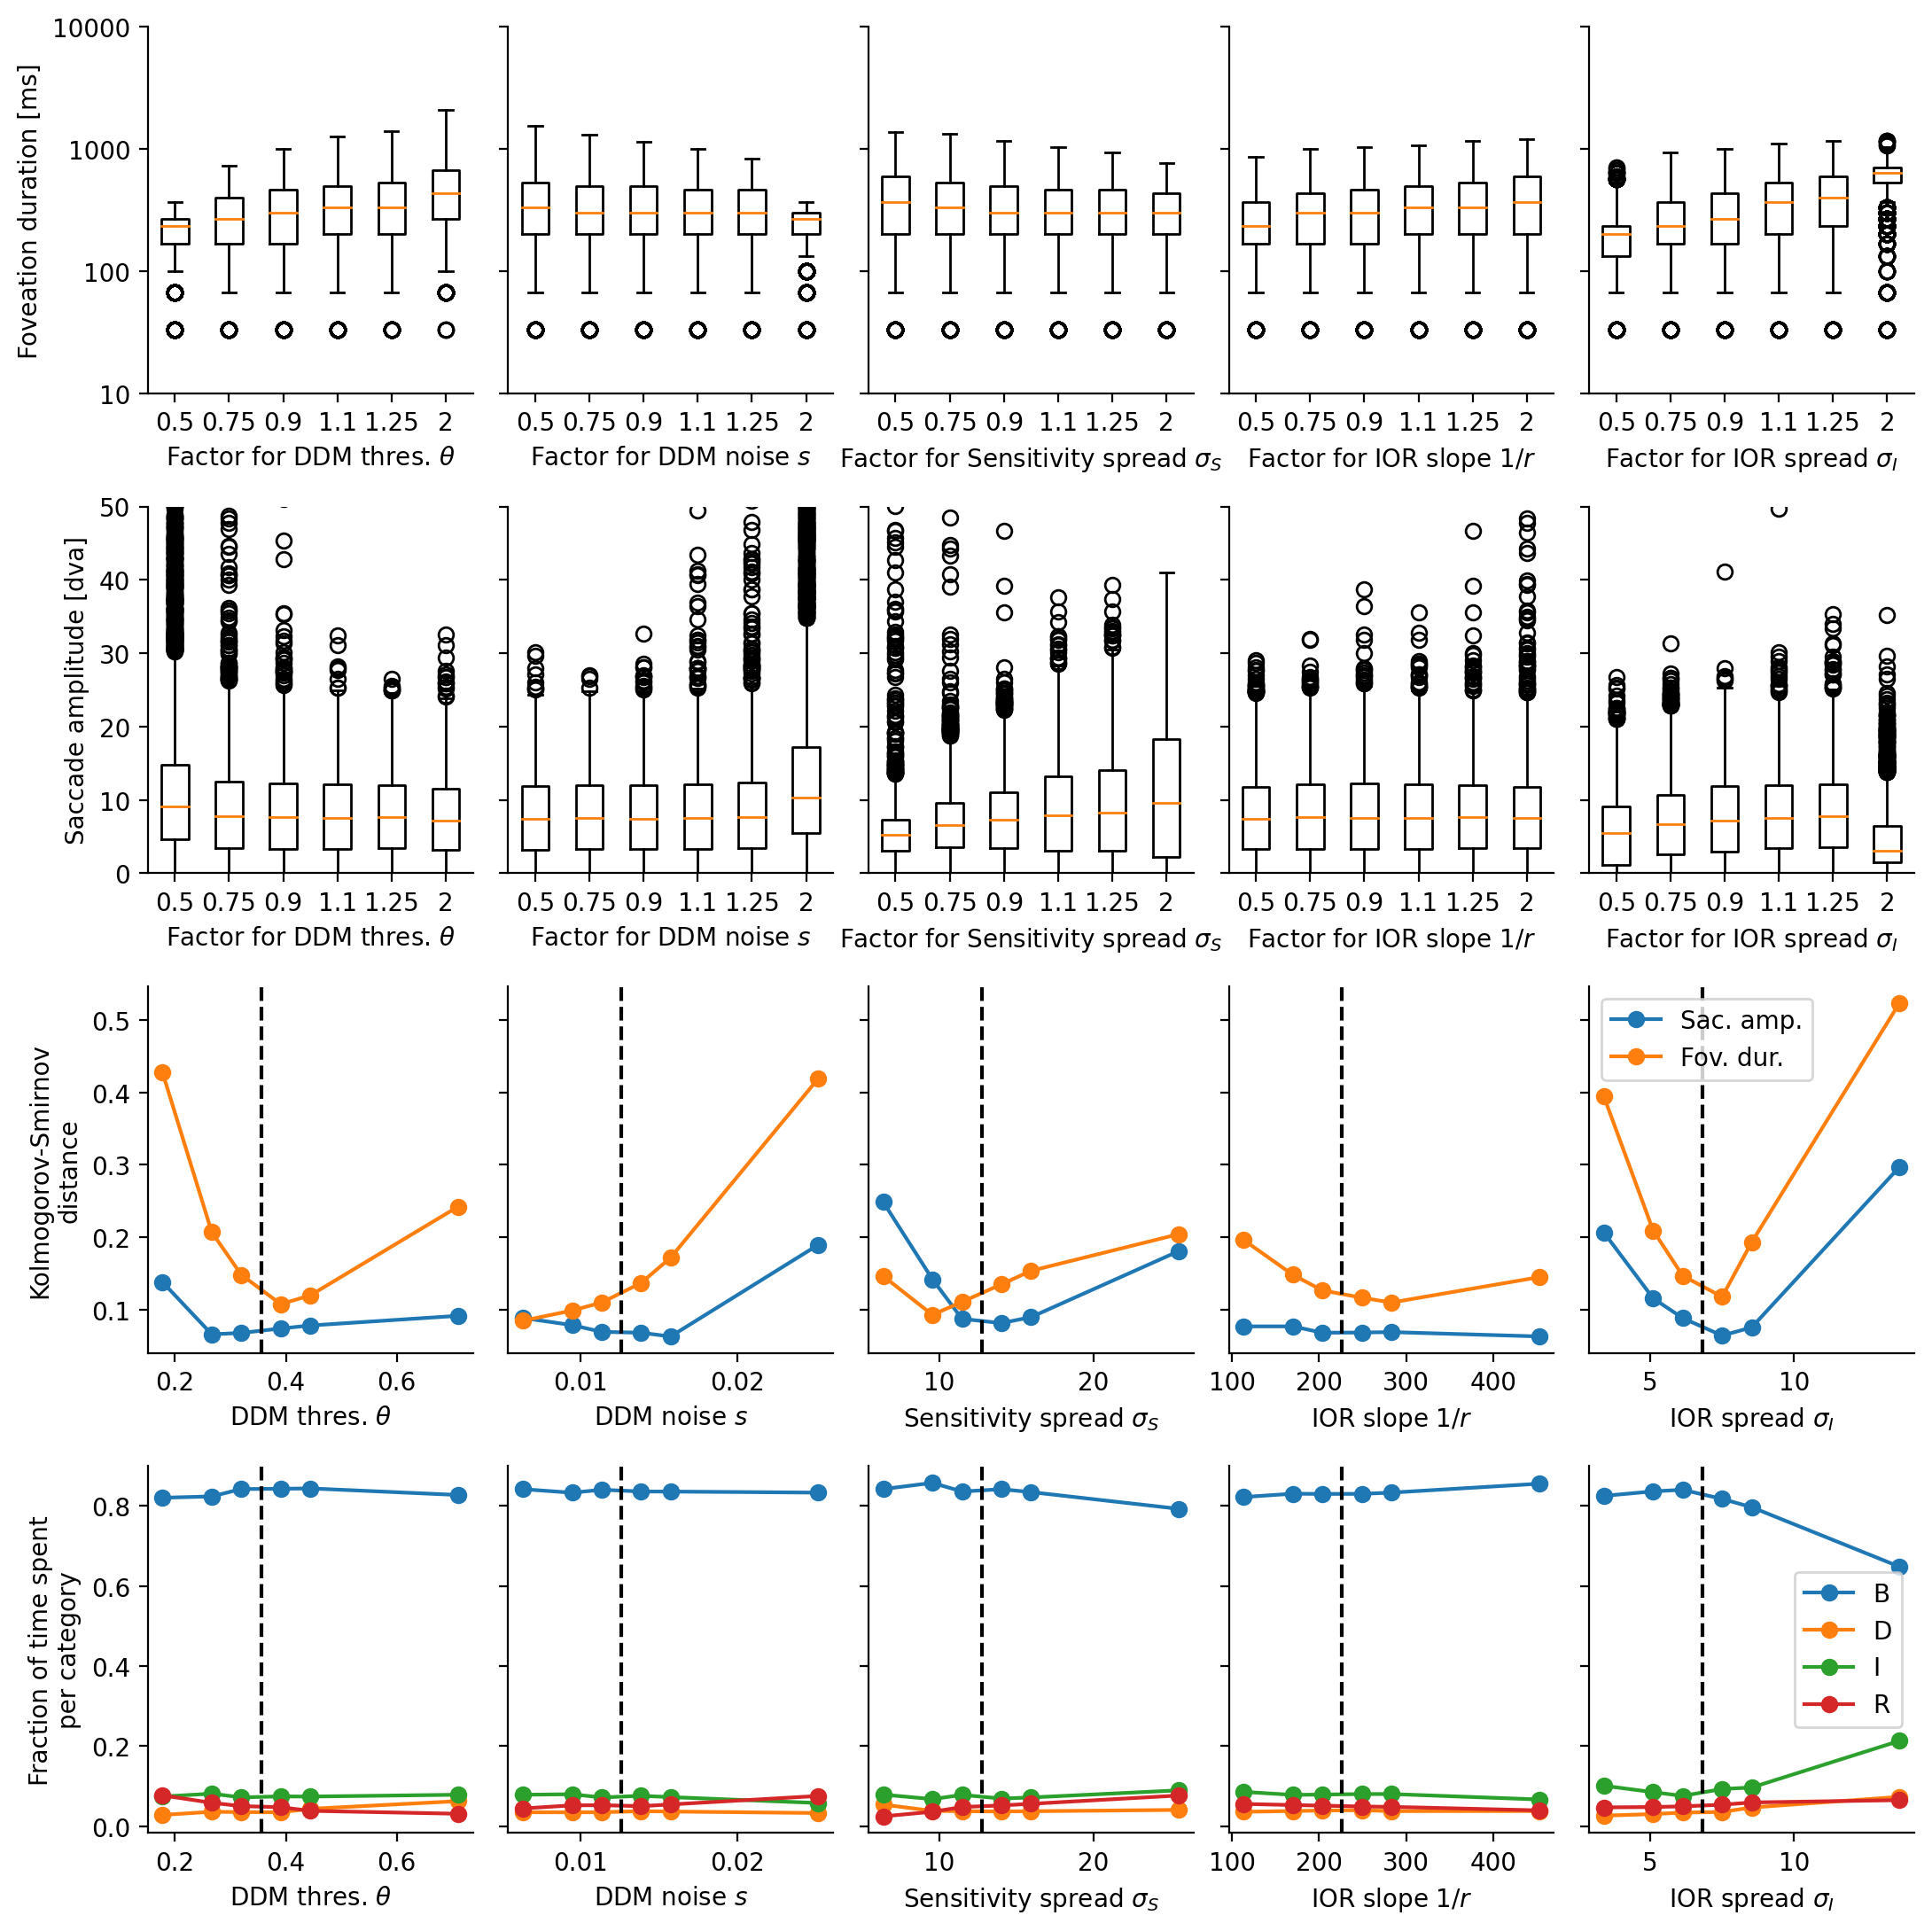

In [3]:
# where to get parameters from? --> previous evolution!
runid = 'loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349'
model = LocationModel(VidCom)
parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity spread $\sigma_S$', r'IOR slope $1/r$', r'IOR spread $\sigma_I$']
relative_par_vals = [0.5, 0.75, 0.9, 1.1, 1.25, 2]

uf.plot_var_pars(model, runid, parameters, par_sym, relative_par_vals)

### Same for object based model...

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-11-13H-00M-58S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-11-13H-00M-58S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

{'ddm_thres': 1.872704436762647, 'ddm_sig': 0.24143508685761073, 'att_dva': 13.720242745930793, 'ior_decay': 198.89746593153282, 'ior_inobj': 0.7572940497067542}


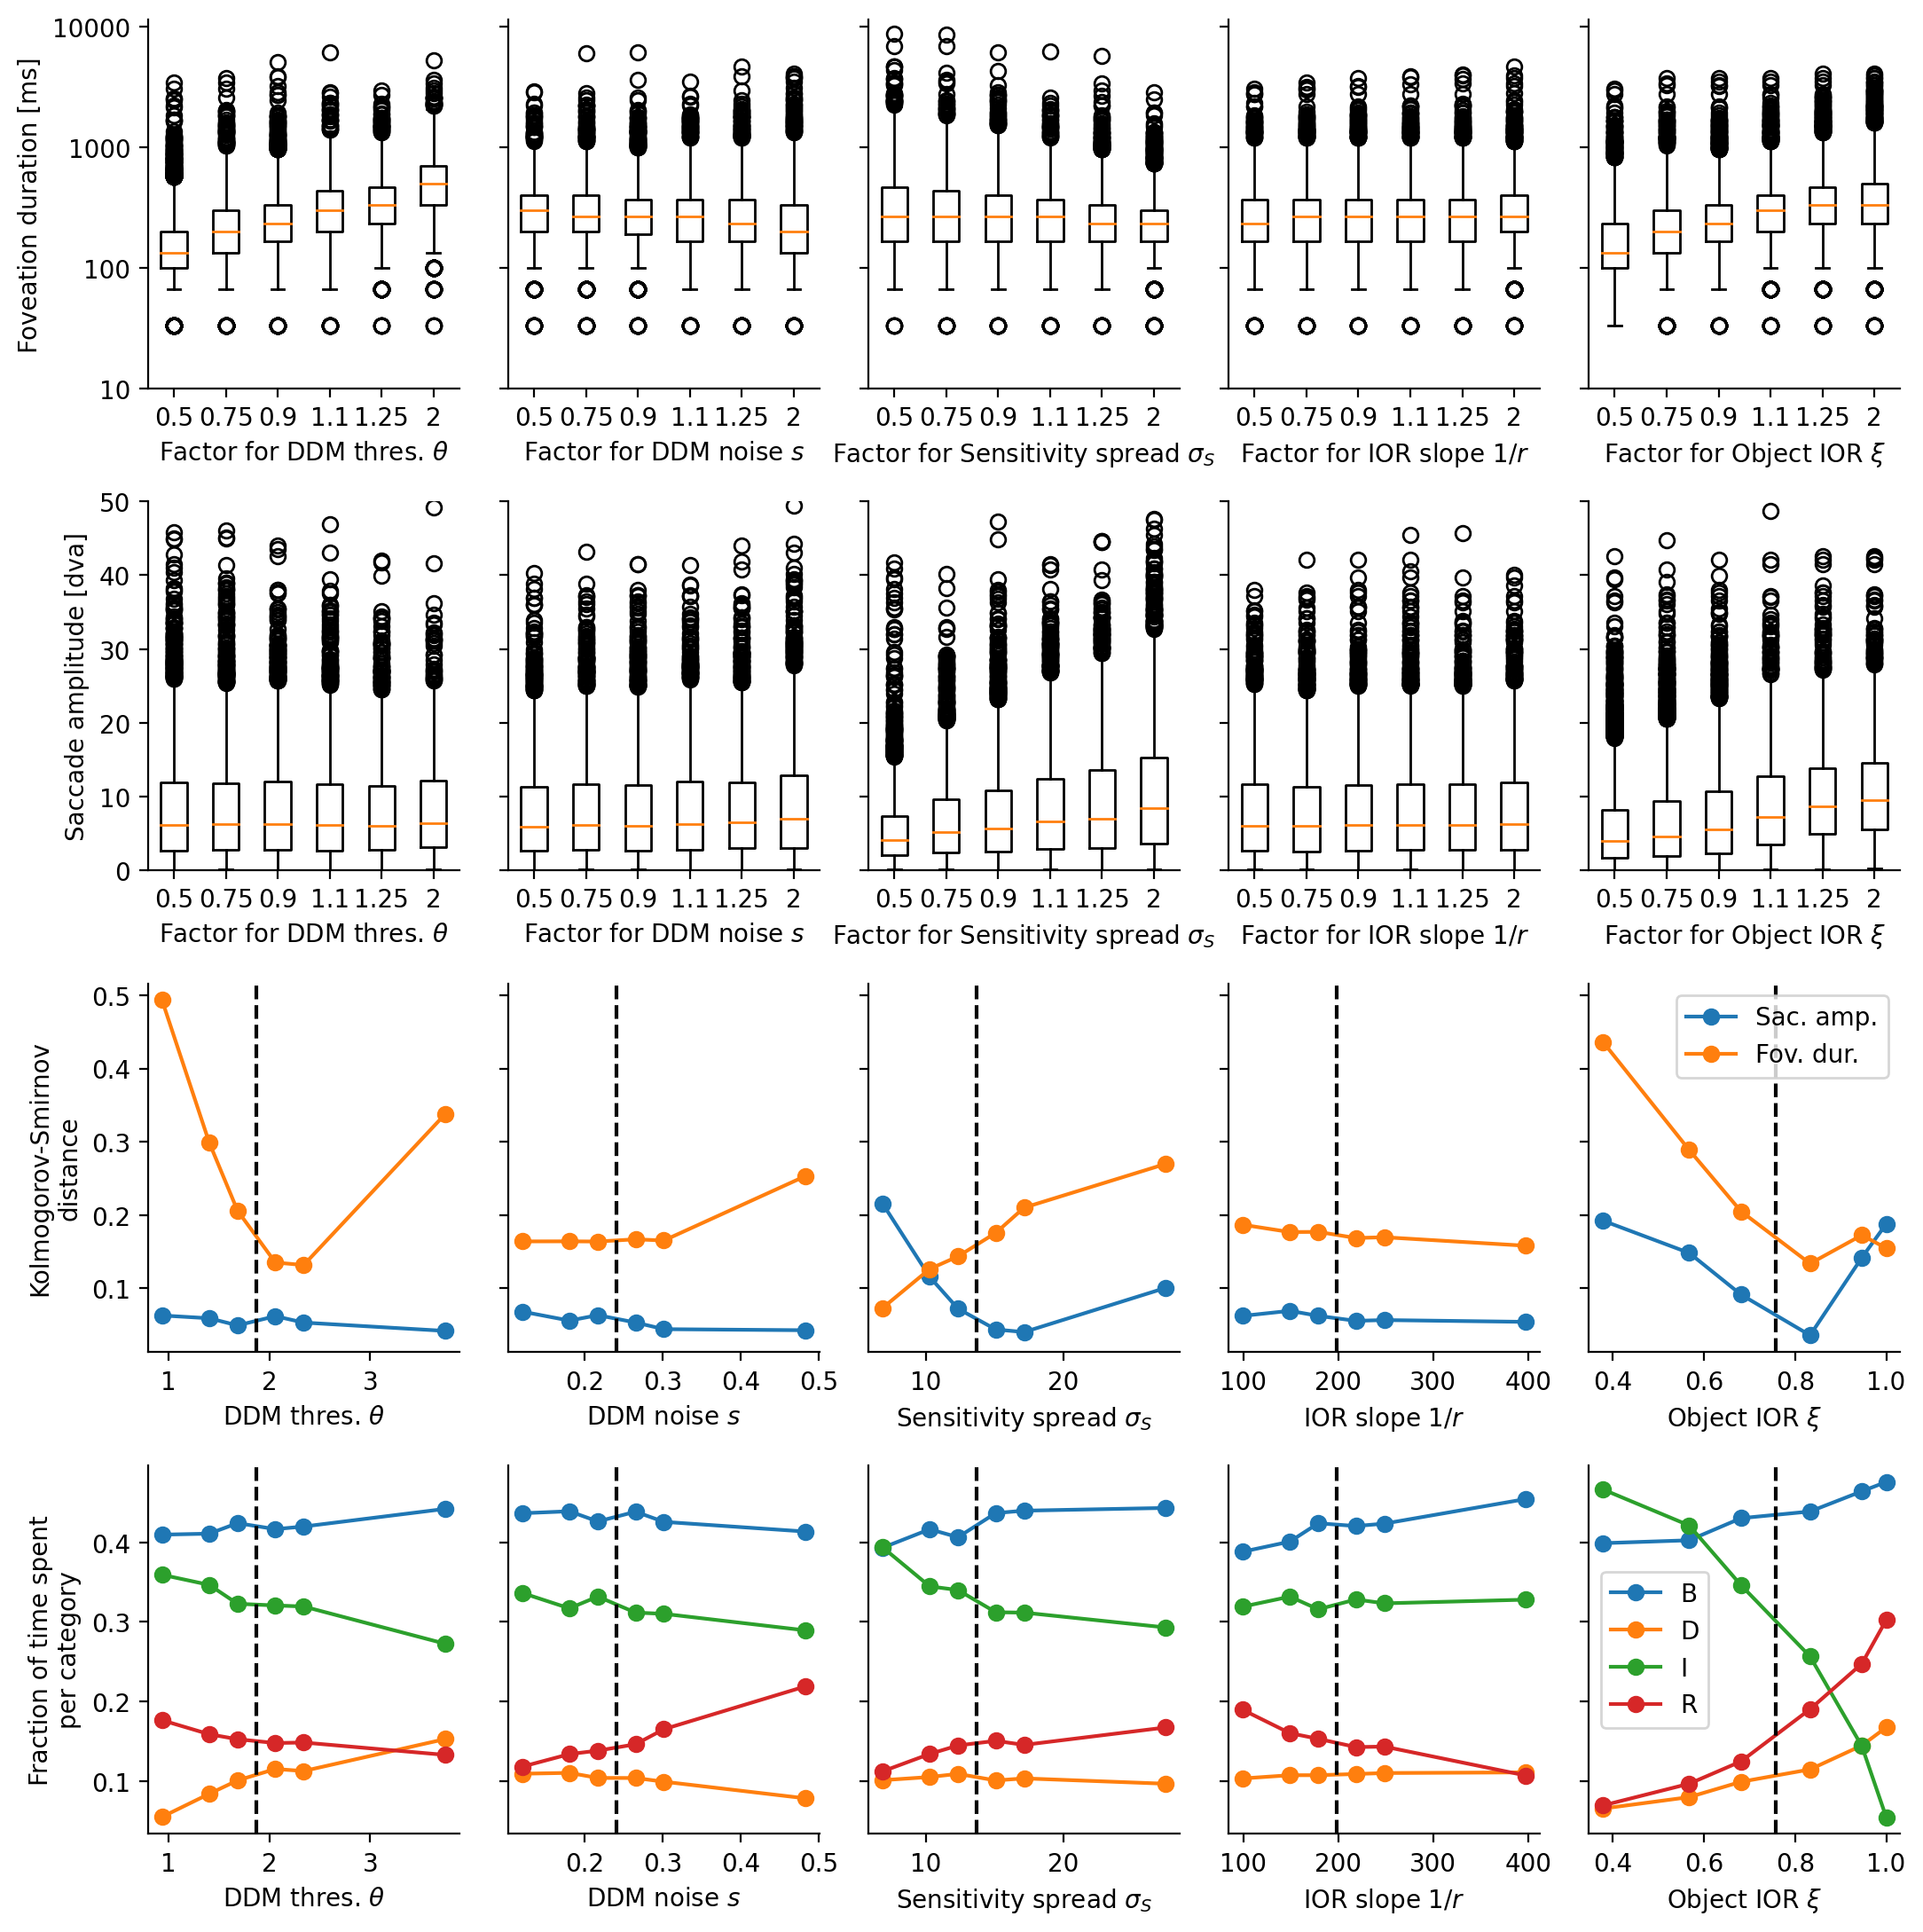

In [4]:
# where to get parameters from? --> previous evolution!
runid = 'obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350'
model = ObjectModel(VidCom)
parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity spread $\sigma_S$', r'IOR slope $1/r$', r'Object IOR $\xi$']
relative_par_vals = [0.5, 0.75, 0.9, 1.1, 1.25, 2]

uf.plot_var_pars(model, runid, parameters, par_sym, relative_par_vals)

## S3-6: Parameter spaces of the 4 models

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-07S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-07S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349.hdf
Trajectory Name: results-2023-03-09-01H-04M-33S
Duration of evaluating initial population 1:02:50.390845
Duration of evolution 1 day, 0:26:10.935231
Eval function: <function optimize_me at 0x7fb1e3f5eb90>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7fb201fdf3b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7fb1fdc8ed40>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7fb1fdc8ecb0>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.1
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 0.3553,	 std: 0.0369
ddm_sig: 	 mean: 0.0

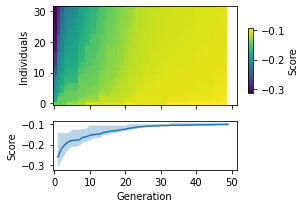

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-09-01H-04M-33S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.1


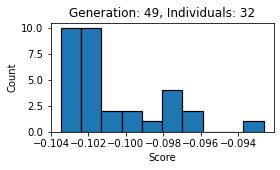

<Figure size 432x288 with 0 Axes>

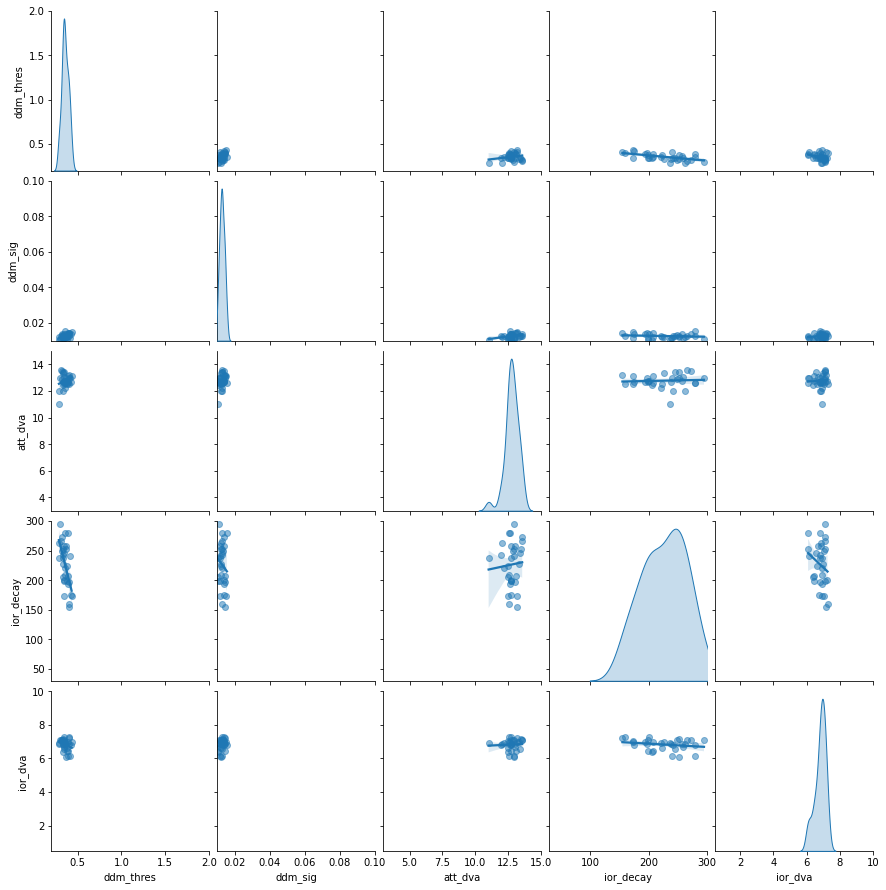

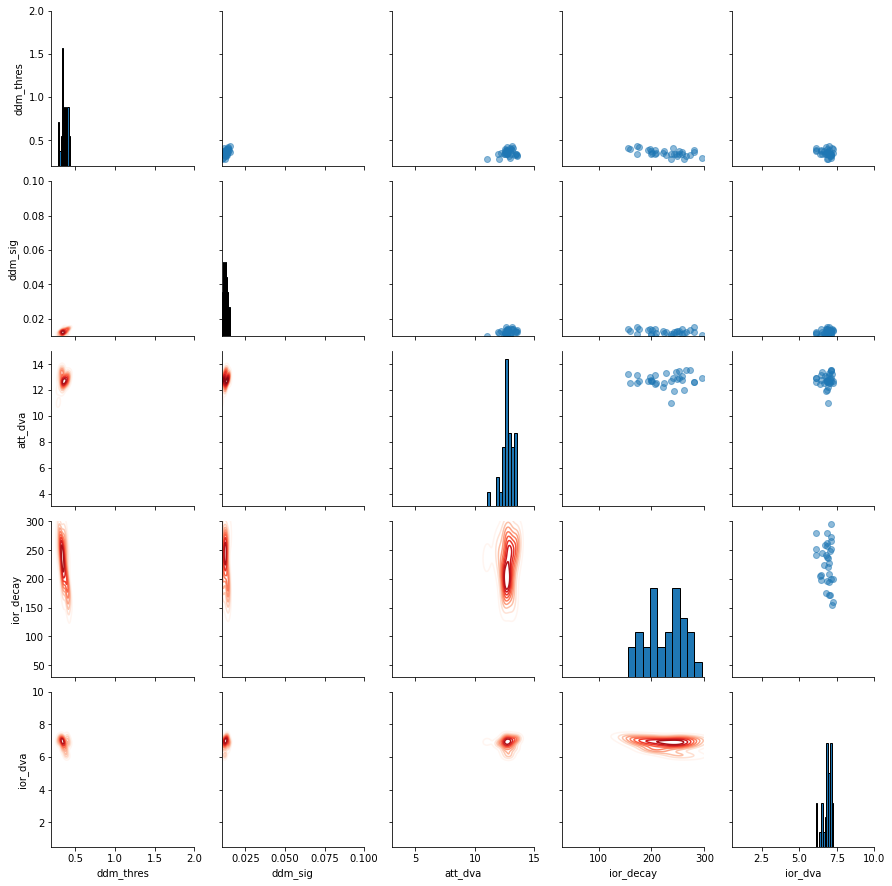

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-27S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-27S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/loc_train_TASEDnet_64-32-50_2023-03-09-01H-02M-20S_22332348.hdf
Trajectory Name: results-2023-03-09-01H-02M-20S
Duration of evaluating initial population 1:08:29.172091
Duration of evolution 1 day, 0:18:27.507685
Eval function: <function optimize_me at 0x7fb1f92e3e60>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7fb201fdf3b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7fb1fdc8ed40>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7fb1fdc8ecb0>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.14
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.4688,	 std: 0.0528
ddm_sig: 	 mean:

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


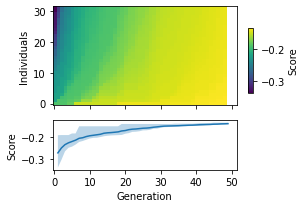

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-09-01H-02M-20S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.14


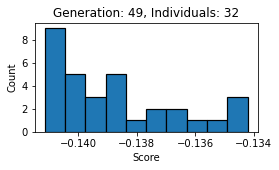

<Figure size 432x288 with 0 Axes>

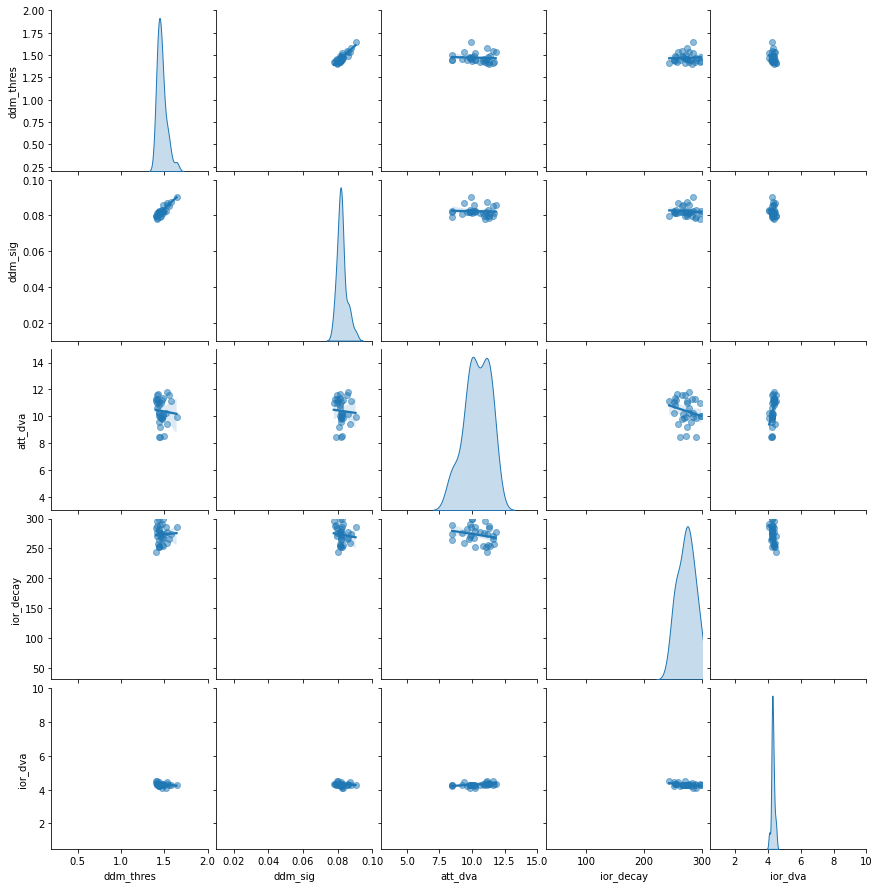

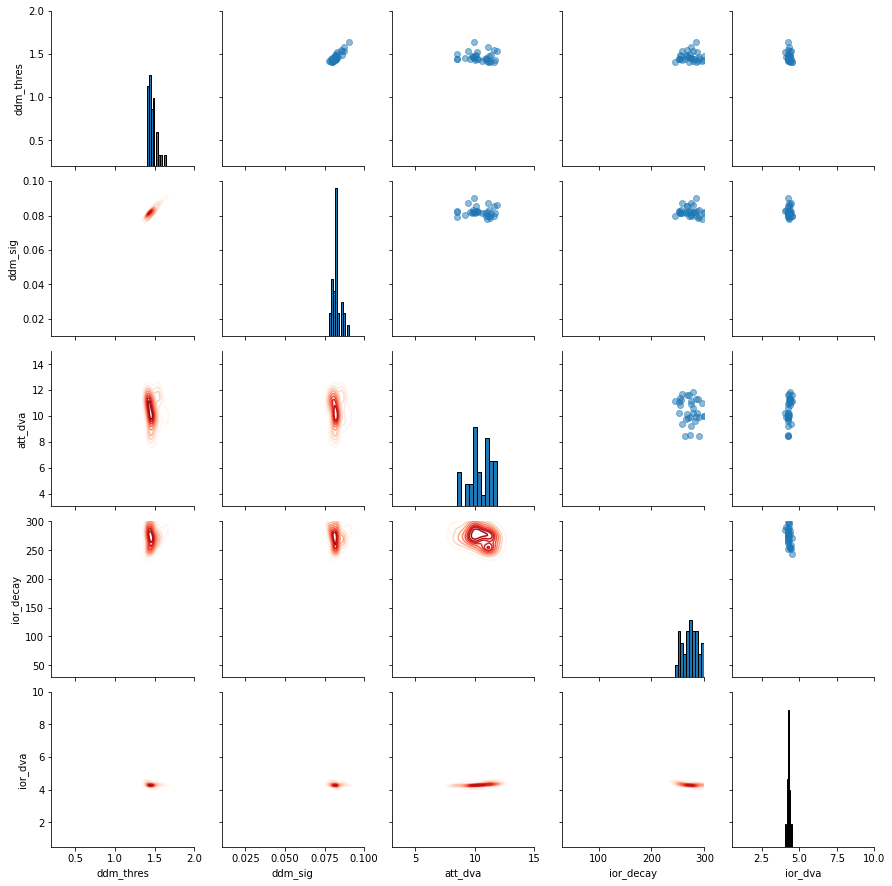

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-47S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-14M-47S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350.hdf
Trajectory Name: results-2023-03-09-01H-04M-58S
Duration of evaluating initial population 0:41:22.436206
Duration of evolution 17:12:13.730171
Eval function: <function optimize_me at 0x7fb1f906fcb0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7fb201fdf3b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7fb1fdc8ed40>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7fb1fdc8ecb0>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.094
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.8727,	 std: 0.1396
ddm_sig: 	 mean: 0

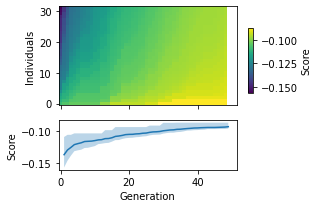

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-09-01H-04M-58S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.094


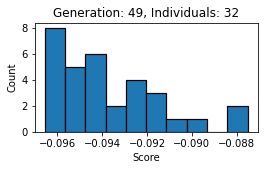

<Figure size 432x288 with 0 Axes>

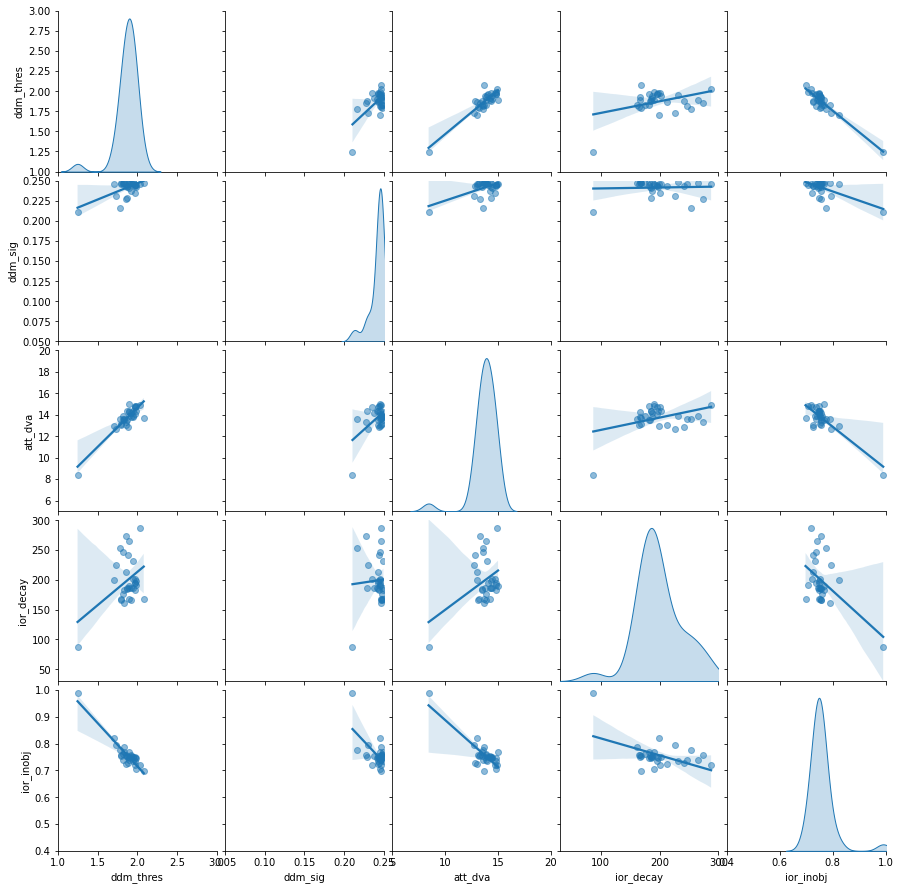

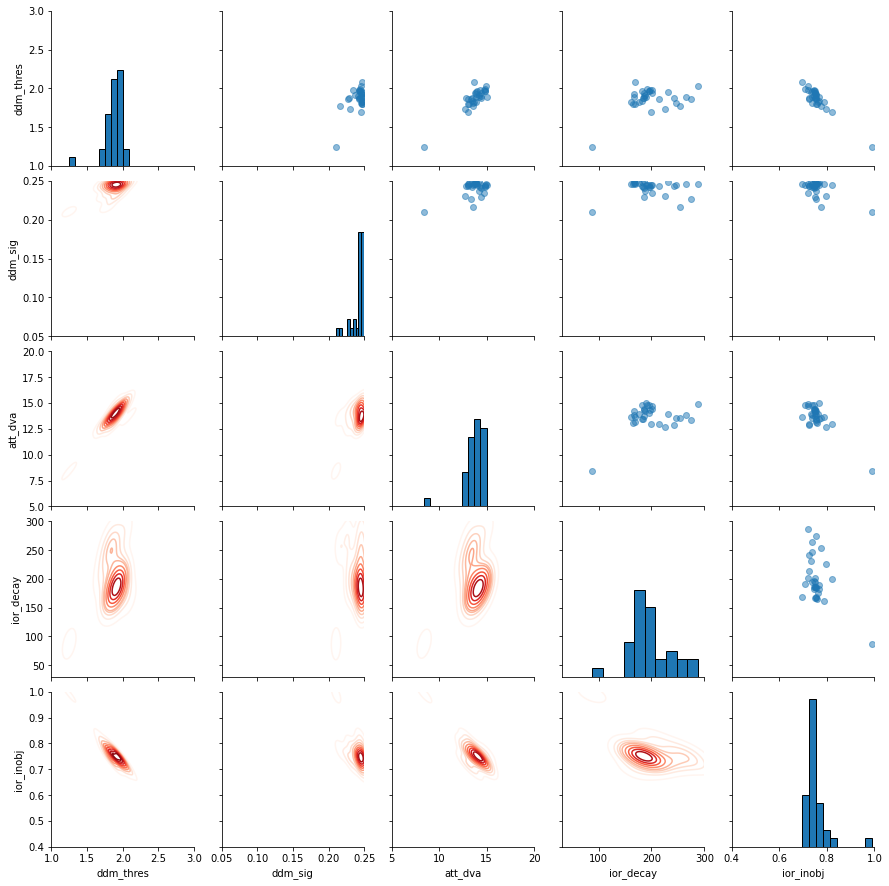

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-15M-09S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-11-12H-15M-09S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/obj_train_None_64-32-50_2023-03-09-01H-05M-43S_22332351.hdf
Trajectory Name: results-2023-03-09-01H-05M-43S
Duration of evaluating initial population 0:45:24.055978
Duration of evolution 17:13:01.289772
Eval function: <function optimize_me at 0x7fb1e3f659e0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7fb201fdf3b0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7fb1fdc8ed40>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7fb1fdc8ecb0>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.16
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 2.8618,	 std: 0.0998
ddm_sig: 	 mean: 0.2

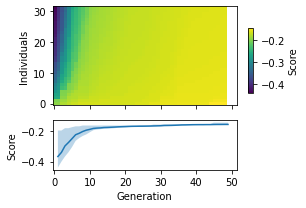

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-09-01H-05M-43S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.16


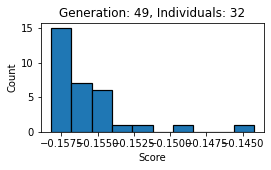

<Figure size 432x288 with 0 Axes>

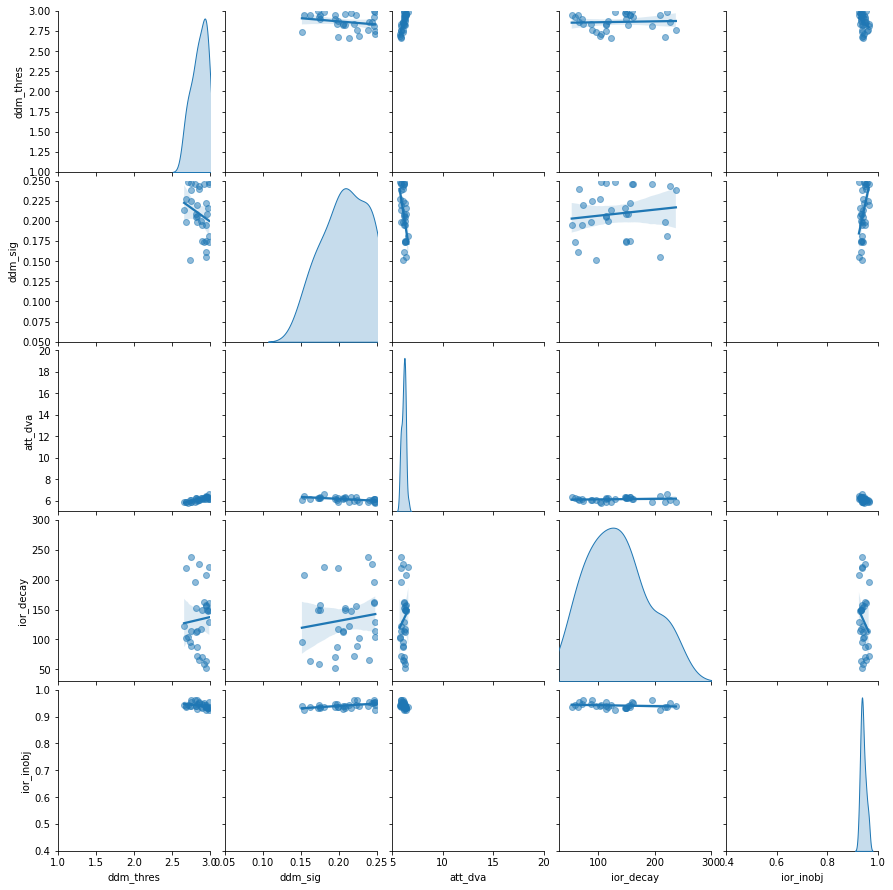

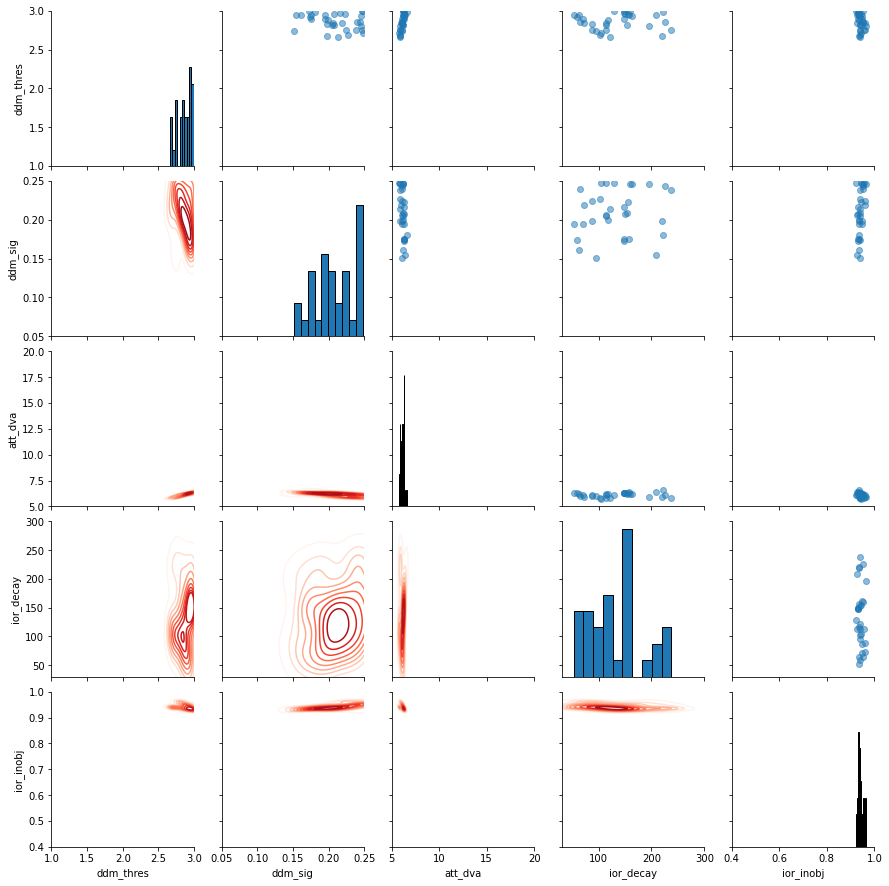

In [30]:
run_ids = [
    'loc_train_molin_64-32-50_2023-03-09-01H-04M-33S_22332349',
    'loc_train_TASEDnet_64-32-50_2023-03-09-01H-02M-20S_22332348',
    'obj_train_molin_64-32-50_2023-03-09-01H-04M-58S_22332350',
    'obj_train_None_64-32-50_2023-03-09-01H-05M-43S_22332351',
]
for runid in run_ids:
    DILLNAME = f'{runid}.dill'
    evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    evol.info()


### S7 see above